# Time Series Classification of ECG Signals






Electrocardiography (ECG) is a method used to record the electrical activity of the heart over a period of time using electrodes placed on the skin. The resulting signals, known as ECG signals, are crucial for diagnosing various heart conditions. This project focuses on the classification of ECG signals into two categories: normal heartbeat and myocardial infarction (heart attack).

The objective of this classification task is to develop a model that can accurately distinguish between normal and abnormal ECG signals, which is critical for timely diagnosis and treatment of heart conditions. By leveraging machine learning techniques, we aim to build a robust classifier that can assist healthcare professionals in identifying patients with myocardial infarction from ECG recordings.


### Packages Imports


In [352]:
import os
import joblib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
from scipy.cluster import hierarchy
from scipy.stats import skew, kurtosis
from scipy.fftpack import fft
import pywt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_val_predict, GridSearchCV
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_curve, auc
from sklearn.datasets import make_classification

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

import xgboost as xgb
from google.colab import drive

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Dropout, Conv1D, MaxPooling1D, Flatten, LSTM, Bidirectional
from tensorflow.keras.optimizers import Adam


# I. Data Preprocessing and Exploratory Data Analysis

## 1. Data Overview

### 1.1 Data Description

The dataset consists of ECG recordings with labels indicating normal or myocardial infarction conditions. Each sample is represented by 96 time points.

### 1.2 Data loading

In [447]:
# Loading the dataset
drive.mount('/content/drive')
file_path = '/content/drive/My Drive/ECG200_TRAIN.txt'
data = pd.read_csv(file_path, header=None)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [448]:
data.head()
data.shape

(100, 1)

## 2. Data Preprocessing

In [449]:
# Check if the column '0' exists in the DataFrame
if 0 in data.columns:
    try:
        # Split the single column into 97 columns (1 Class + 96 Features)
        data = data[0].str.split(expand=True)

        # Convert all columns to float
        data = data.astype(float)

        # Rename columns
        data.columns = ["Class"] + [f"Feature{i}" for i in range(1, 97)]

        # Check for missing values
        if data.isnull().values.any():
            print("Warning: Missing values found after splitting. Consider handling them appropriately.")
    except Exception as e:
        print(f"An error occurred while processing the data: {e}")
else:
    print("Error: Column '0' does not exist in the DataFrame.")


### 2.1. Checking for Missing Values

In [450]:
# Check for null values in each column
null_counts = data.isnull().sum()

# Print the number of null values
print("Number of null values in each column:")
print(null_counts)

# Print a summary message
if null_counts.sum() == 0:
    print("No missing values found in the dataset.")
else:
    print(f"Total number of missing values: {null_counts.sum()}")


Number of null values in each column:
Class        0
Feature1     0
Feature2     0
Feature3     0
Feature4     0
            ..
Feature92    0
Feature93    0
Feature94    0
Feature95    0
Feature96    0
Length: 97, dtype: int64
No missing values found in the dataset.


### 2.2. Splitting Features and Labels

In [451]:
# Split features and labels
X = data.drop(columns=["Class"]).values  # Extract feature values
y = data["Class"].astype('category').cat.codes  # Convert labels to categorical codes

# Check the shapes of X and y
print("Shape of X (features):", X.shape)
print("Shape of y (labels):", y.shape)

# Print unique classes in y to verify label encoding
print("Unique classes in y:", y.unique())

# Display the first few rows of the data
data.head()


Shape of X (features): (100, 96)
Shape of y (labels): (100,)
Unique classes in y: [0 1]


,Class,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,Feature9,...,Feature87,Feature88,Feature89,Feature90,Feature91,Feature92,Feature93,Feature94,Feature95,Feature96
0,-1.0,0.502055,0.542163,0.722383,1.428885,2.136516,2.281149,1.936274,1.468890,1.008845,...,0.931043,0.610298,0.638894,0.684679,0.583238,0.640522,0.708585,0.705011,0.713815,0.433765
1,1.0,0.147647,0.804668,0.367771,0.243894,0.026614,-0.274402,0.096731,-0.747731,-1.609777,...,-0.533503,-0.400228,0.176084,1.111768,2.438428,2.734889,1.736054,0.036857,-1.265074,-0.208024
2,-1.0,0.316646,0.243199,0.370471,1.063738,1.678187,1.759558,1.697717,1.612159,1.168188,...,0.764229,0.610621,0.552900,0.566786,0.604002,0.777068,0.812345,0.748848,0.818042,0.539347
3,-1.0,1.168874,2.075901,1.760141,1.606446,1.949046,1.302842,0.459332,0.516412,0.852180,...,0.419006,0.723888,1.323947,2.136488,1.746597,1.470220,1.893512,1.256949,0.800407,0.731540
4,1.0,0.648658,0.752026,2.636231,3.455716,2.118157,0.520620,-0.188627,0.780818,0.933775,...,-0.097869,-0.136787,-0.340237,-0.089441,-0.080297,-0.192584,-0.304704,-0.454556,0.314590,0.582190


### 2.3. Generating Summary Statistics

In [452]:
# Summary statistics for the original data

# Convert X back to a DataFrame to use pandas' describe method
X_df = pd.DataFrame(X, columns=[f"Feature{i}" for i in range(1, 97)])

# Get summary statistics
summary_stats = X_df.describe()

# Print a message before the summary statistics
print("Summary statistics for the ECG features:")

# Print the summary statistics
summary_stats


Summary statistics for the ECG features:


,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,Feature9,Feature10,...,Feature87,Feature88,Feature89,Feature90,Feature91,Feature92,Feature93,Feature94,Feature95,Feature96
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.708438,1.422151,2.039149,2.126455,1.551616,0.762251,0.282647,0.333630,0.372973,0.210769,...,0.190412,0.174286,0.205107,0.286484,0.412464,0.459377,0.389852,0.282864,0.182829,0.174863
std,0.593513,0.927972,1.046880,1.098754,0.954734,0.963111,1.096712,0.877640,0.761753,0.739185,...,0.403825,0.434002,0.454395,0.589879,0.772104,0.871045,0.832312,0.665548,0.619799,0.413644
min,-0.706305,-1.100715,-1.321589,-1.076313,-1.247922,-1.482391,-1.598712,-1.508060,-1.609777,-1.600454,...,-0.533503,-0.691436,-0.516631,-0.574304,-0.559178,-0.530917,-0.738019,-0.970796,-1.862314,-1.238622
25%,0.318643,0.779810,1.525548,1.511639,0.966292,0.022470,-0.603378,-0.464767,-0.075355,-0.205867,...,-0.131730,-0.140244,-0.121657,-0.144015,-0.070247,-0.098634,-0.107719,-0.119784,-0.124178,-0.043105
50%,0.581008,1.232191,2.152552,2.234408,1.746861,0.574297,0.120230,0.366122,0.457255,0.182365,...,0.086719,0.089474,0.107957,0.129133,0.170798,0.205220,0.101618,0.136106,0.124148,0.152284
75%,0.994760,2.093703,2.707411,2.865394,2.163355,1.502335,1.226563,1.008876,0.990675,0.776566,...,0.439861,0.468588,0.480635,0.613990,0.588429,0.630966,0.560136,0.594807,0.541680,0.429055
max,2.689017,3.535038,3.850263,4.199145,3.720899,3.026452,2.454195,2.220327,2.122435,1.916524,...,1.376751,1.497244,1.436900,2.190151,3.047309,3.269882,3.332053,2.653741,1.930880,1.372607


Looking at the summary statistics, it's clear that our features span a wide range of values, from around -2 to 4. Most features show a balanced distribution, with their mean and median being close together, suggesting symmetric or near-symmetric distributions. However, there are differences in variability among the features, with some having a smaller spread than others. The presence of both positive and negative values across several features indicates that our dataset encompasses a diverse range of measurements.

To address these disparities and ensure that no single feature dominates the analysis due to its larger scale, we are going to normalize our data.

### 2.4. Normalizing ECG Data for Consistent Feature Scaling

In [453]:
# Normalize the data using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_df)

# Convert the scaled data back to a DataFrame to use pandas' describe method
X_scaled_df = pd.DataFrame(X_scaled, columns=[f"Feature{i}" for i in range(1, 97)])

# Get summary statistics for the normalized data
summary_stats_scaled = X_scaled_df.describe()

# Print a message before the summary statistics
print("Summary statistics for the normalized ECG features:")

# Print the summary statistics
summary_stats_scaled


Summary statistics for the normalized ECG features:


,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,Feature9,Feature10,...,Feature87,Feature88,Feature89,Feature90,Feature91,Feature92,Feature93,Feature94,Feature95,Feature96
count,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,...,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02
mean,-1.354472e-16,-3.075318e-16,2.856049e-16,-1.132427e-16,-2.464695e-16,-1.976197e-16,8.881784e-18,9.769963e-17,1.554312e-17,-3.330669e-17,...,7.438494e-17,-1.731948e-16,8.881784e-18,-2.331468e-17,2.109424e-17,-2.997602e-17,-8.659740e-17,4.329870e-17,-6.772360e-17,-1.176836e-16
std,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00,...,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00
min,-2.395684e+00,-2.732384e+00,-3.226415e+00,-2.929595e+00,-2.947042e+00,-2.342358e+00,-1.724096e+00,-2.109028e+00,-2.615990e+00,-2.462640e+00,...,-1.801677e+00,-2.004790e+00,-1.596352e+00,-1.466615e+00,-1.264775e+00,-1.142630e+00,-1.361933e+00,-1.893139e+00,-3.316313e+00,-3.434371e+00
25%,-6.600664e-01,-6.956855e-01,-4.930732e-01,-5.623765e-01,-6.161640e-01,-7.719855e-01,-8.119620e-01,-9.142908e-01,-5.915120e-01,-5.664811e-01,...,-8.017461e-01,-7.283701e-01,-7.227412e-01,-7.334856e-01,-6.283394e-01,-6.438493e-01,-6.008294e-01,-6.080347e-01,-4.978293e-01,-5.296014e-01
50%,-2.157861e-01,-2.057357e-01,1.088706e-01,9.874561e-02,2.055319e-01,-1.961356e-01,-1.488406e-01,3.720853e-02,1.111996e-01,-3.861868e-02,...,-2.580710e-01,-1.964022e-01,-2.148787e-01,-2.680954e-01,-3.145740e-01,-2.932531e-01,-3.480497e-01,-2.216175e-01,-9.515561e-02,-5.486217e-02
75%,4.848503e-01,7.273229e-01,6.415525e-01,6.759126e-01,6.439706e-01,7.723023e-01,8.650136e-01,7.732648e-01,8.149809e-01,7.692896e-01,...,6.208289e-01,6.815284e-01,6.094181e-01,5.580061e-01,2.290512e-01,1.979846e-01,2.056222e-01,4.710622e-01,5.818968e-01,6.176144e-01
max,3.353857e+00,2.288357e+00,1.738726e+00,1.895904e+00,2.283579e+00,2.362769e+00,1.990028e+00,2.160569e+00,2.308196e+00,2.319241e+00,...,2.952557e+00,3.063634e+00,2.724500e+00,3.243475e+00,3.429745e+00,3.242844e+00,3.552780e+00,3.580237e+00,2.834561e+00,2.910181e+00


## 3. Exploratory Data Analysis (EDA)

### 3.1. Class Distribution Plot
Understanding the class distribution is crucial because it provides insights into the balance of the dataset. A balanced dataset is essential for training effective machine learning models, while an imbalanced dataset may require specific techniques to address bias.

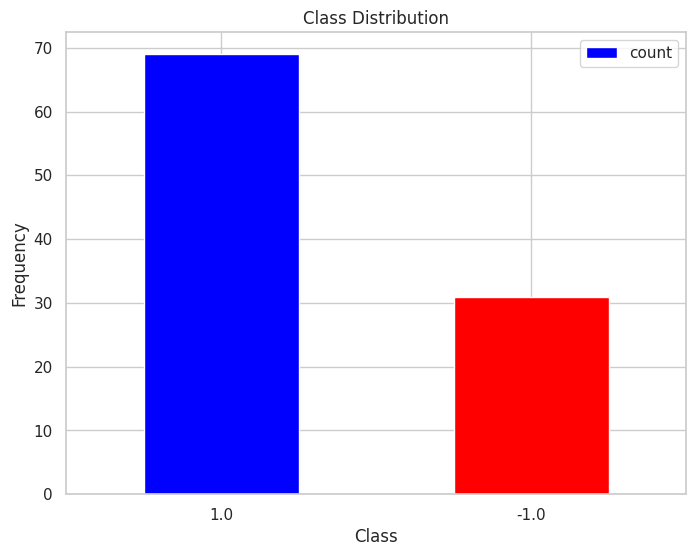

In [328]:
class_labels = data["Class"].unique()
class_mapping = {code: label for code, label in enumerate(class_labels)}
y_original = pd.Series(y).map(class_mapping)

# Get class distribution
class_distribution = y_original.value_counts()

# Plot the class distribution
plt.figure(figsize=(8, 6))
class_distribution.plot(kind='bar', color=['blue', 'red'], legend=True)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.show()


The class distribution shows a significant imbalance, with the majority class (1.0) having more instances than the minority class (-1.0). This indicates a potential need for techniques to address class imbalance, such as resampling or using appropriate evaluation metrics.

### 3.2. Checking for Missing or Infinite Values and Plotting Samples

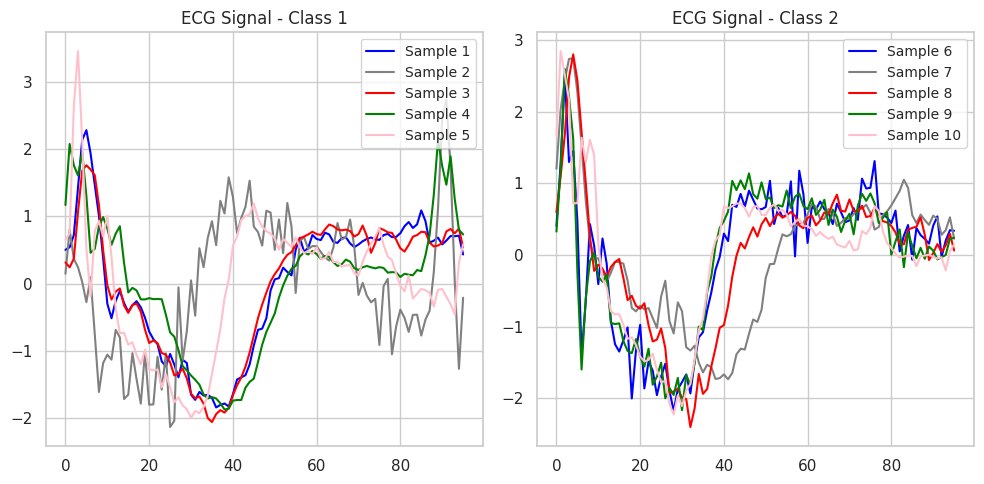

In [329]:
# Check for missing or infinite values
if np.any(np.isnan(X)) or np.any(np.isinf(X)):
    X[np.isnan(X)] = 0  # Replace NaN with 0
    X[np.isinf(X)] = 0  # Replace infinite values with 0

# Plot for Class 1 samples
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
for i in range(5):
    plt.plot(X[i], color=['blue', 'grey', 'red', 'green', 'pink'][i], label=f'Sample {i+1}')
plt.title('ECG Signal - Class 1')
plt.legend(loc='upper right', fontsize='small')

# Plot for Class 2 samples
plt.subplot(1, 2, 2)
for i in range(5, 10):
    plt.plot(X[i], color=['blue', 'grey', 'red', 'green', 'pink'][i-5], label=f'Sample {i+1}')
plt.title('ECG Signal - Class 2')
plt.legend(loc='upper right', fontsize='small')

plt.tight_layout()
plt.show()


The plotted ECG signals show distinct patterns between the two classes. Class 1 samples exhibit higher variability and more pronounced peaks compared to Class 2, which appears to have more consistent and less variable signals. This visual difference suggests that the ECG signal patterns could be useful features for distinguishing between normal and myocardial infarction cases.

### 3.3. Clustered Correlation Heatmap
This script helps us understand how different variables relate to each other in our dataset. It's like organizing things that are similar so they're together. First, it groups variables based on how much they're alike in terms of their relationships with each other. Then, it rearranges them to make it easier to see these groups. Finally, it shows us this organization using a colorful heatmap. This heatmap helps us see which groups of variables have similar relationships, making it easier to understand our data.

<ipython-input-330-5059a15b3405>:5: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  cluster_cor_matrix = hierarchy.linkage(1 - np.abs(cor_matrix), method='average')


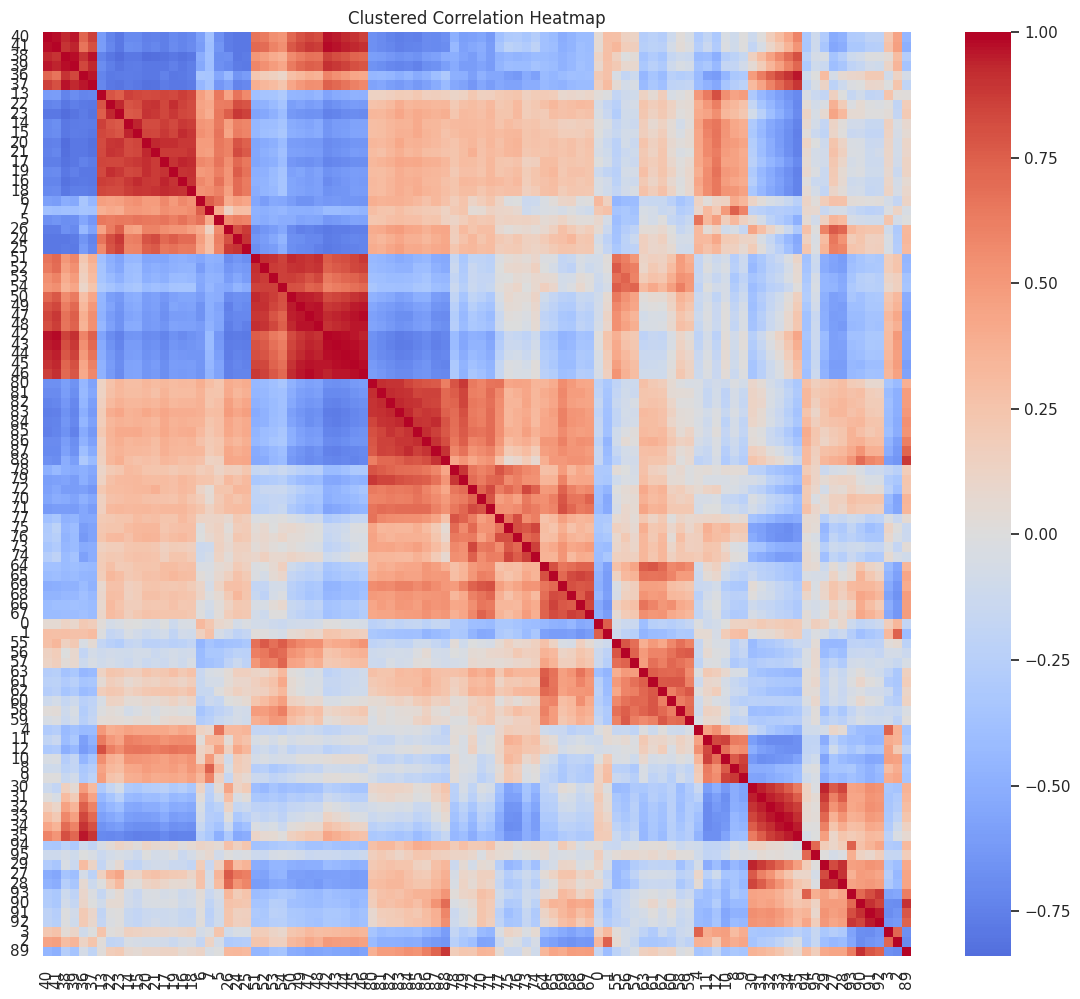

In [330]:
# Calculate the correlation matrix
cor_matrix = np.corrcoef(X, rowvar=False)

# Cluster the correlation matrix
cluster_cor_matrix = hierarchy.linkage(1 - np.abs(cor_matrix), method='average')

# Reorder the correlation matrix based on clustering
reordered_indices = hierarchy.leaves_list(cluster_cor_matrix)
reordered_cor_matrix = cor_matrix[np.ix_(reordered_indices, reordered_indices)]

# Plot the reordered correlation matrix using seaborn heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(reordered_cor_matrix, cmap="coolwarm", center=0, annot=False, fmt=".2f", cbar=True,
            xticklabels=reordered_indices, yticklabels=reordered_indices)
plt.title("Clustered Correlation Heatmap")
plt.show()


The improved clustered correlation heatmap reveals clear clusters of features that are highly correlated. These clusters can guide feature selection by identifying groups of features with similar information, allowing for the removal of redundant features.



# II. First approach

In the initial approach, we trained several machine learning models using raw data as inputs to evaluate their performance on a binary classification task. The models included Support Vector Machines (SVM), Random Forest, K-Nearest Neighbors (KNN), Multi-layer Perceptron (MLP), and Gradient Boosting Machine (GBM). We employed a 5-fold stratified cross-validation strategy to ensure robust performance evaluation across different data splits. To address potential class imbalance, we utilized techniques like class weighting, Synthetic Minority Over-sampling Technique (SMOTE), and Random Under-sampling. Each model's performance was assessed based on cross-validated accuracy and a detailed classification report, providing insights into their precision, recall, and F1-scores. This comprehensive approach allowed us to identify the best-performing models and their suitability for the given classification problem.

## 2. Model Training and Evaluation

### 2.1. Support Vector Machine (SVM)

In [331]:

# Define the cross-validation strategy (5-fold stratified cross-validation)
cv = StratifiedKFold(n_splits=5)

# Train the SVM model with cross-validation and predict
svm_model_cv = SVC(kernel='rbf')  # Radial Basis Function (RBF) kernel
y_pred_cv = cross_val_predict(svm_model_cv, X_scaled, y, cv=cv)

# Calculate the cross-validated accuracy
svm_accuracy_cv = accuracy_score(y, y_pred_cv)

# Print the cross-validated performance
print("Cross-validated performance:")
print("Accuracy:", svm_accuracy_cv)

# Generate and print the classification report
print("\nClassification Report:")
print(classification_report(y, y_pred_cv))


Cross-validated performance:
Accuracy: 0.85

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.71      0.75        31
           1       0.88      0.91      0.89        69

    accuracy                           0.85       100
   macro avg       0.83      0.81      0.82       100
weighted avg       0.85      0.85      0.85       100



The Support Vector Machine (SVM) model, using 5-fold stratified cross-validation, achieved an overall accuracy of 0.85. The model shows strong performance on the majority class (Myocardial Infarction) with a precision of 0.88, recall of 0.91, and F1-score of 0.89. However, the performance on the minority class (Normal Heartbeat) is lower, with a precision of 0.79, recall of 0.71, and F1-score of 0.75, indicating potential issues with class imbalance. The macro average F1-score is 0.82, and the weighted average F1-score is 0.85, suggesting that while the model performs well overall, further steps to address class imbalance, such as resampling or class weighting, along with hyperparameter tuning, could enhance performance, particularly for the minority class.

#### 2.2.1 Using Class Weights in SVM

In [332]:
# Define the cross-validation strategy (5-fold stratified cross-validation)
cv = StratifiedKFold(n_splits=5)

# Train the SVM model with class weights to handle class imbalance
svm_model_cv = SVC(kernel='rbf', class_weight='balanced')  # Radial Basis Function (RBF) kernel
y_pred_cv = cross_val_predict(svm_model_cv, X_scaled, y, cv=cv)

# Calculate the cross-validated accuracy
svm_accuracy_cv = accuracy_score(y, y_pred_cv)

# Print the cross-validated performance
print("Cross-validated performance with class weighting:")
print("Accuracy:", svm_accuracy_cv)

# Generate and print the classification report
print("\nClassification Report:")
print(classification_report(y, y_pred_cv))


Cross-validated performance with class weighting:
Accuracy: 0.82

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.77      0.73        31
           1       0.89      0.84      0.87        69

    accuracy                           0.82       100
   macro avg       0.79      0.81      0.80       100
weighted avg       0.83      0.82      0.82       100



#### 2.2.2 Oversampling the Minority Class

In [333]:
# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# Define the cross-validation strategy (5-fold stratified cross-validation)
cv = StratifiedKFold(n_splits=5)

# Train the SVM model on the resampled data
svm_model_cv = SVC(kernel='rbf')
y_pred_cv = cross_val_predict(svm_model_cv, X_resampled, y_resampled, cv=cv)

# Calculate the cross-validated accuracy
svm_accuracy_cv = accuracy_score(y_resampled, y_pred_cv)

# Print the cross-validated performance
print("Cross-validated performance with SMOTE:")
print("Accuracy:", svm_accuracy_cv)

# Generate and print the classification report
print("\nClassification Report:")
print(classification_report(y_resampled, y_pred_cv))


Cross-validated performance with SMOTE:
Accuracy: 0.8840579710144928

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.94      0.89        69
           1       0.93      0.83      0.88        69

    accuracy                           0.88       138
   macro avg       0.89      0.88      0.88       138
weighted avg       0.89      0.88      0.88       138



#### 2.2.3 Undersampling the Majority Class

In [334]:
# Apply RandomUnderSampler to balance the dataset
undersampler = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(X_scaled, y)

# Define the cross-validation strategy (5-fold stratified cross-validation)
cv = StratifiedKFold(n_splits=5)

# Train the SVM model on the resampled data
svm_model_cv = SVC(kernel='rbf')
y_pred_cv = cross_val_predict(svm_model_cv, X_resampled, y_resampled, cv=cv)

# Calculate the cross-validated accuracy
svm_accuracy_cv = accuracy_score(y_resampled, y_pred_cv)

# Print the cross-validated performance
print("Cross-validated performance with undersampling:")
print("Accuracy:", svm_accuracy_cv)

# Generate and print the classification report
print("\nClassification Report:")
print(classification_report(y_resampled, y_pred_cv))


Cross-validated performance with undersampling:
Accuracy: 0.8064516129032258

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.84      0.81        31
           1       0.83      0.77      0.80        31

    accuracy                           0.81        62
   macro avg       0.81      0.81      0.81        62
weighted avg       0.81      0.81      0.81        62



#### Conclusion
Oversampling with SMOTE provides the highest accuracy and balanced performance across classes, making it the most effective technique for this dataset.
Class weighting improves recall for the minority class but achieves a slightly lower overall accuracy compared to SMOTE.
Undersampling balances performance metrics but results in a lower overall accuracy due to the reduced dataset size.

For this specific classification task, Oversampling the Minority Class using SMOTE is recommended to handle class imbalance effectively, as it significantly improves the model's performance on both classes, achieving a higher overall accuracy and balanced precision and recall.

### 2.2. Random Forest


In [335]:
# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# Define the cross-validation strategy (5-fold stratified cross-validation)
cv = StratifiedKFold(n_splits=5)

# Train the Random Forest model on the resampled data
rf_model_cv = RandomForestClassifier()
y_pred_cv = cross_val_predict(rf_model_cv, X_resampled, y_resampled, cv=cv)

# Calculate the cross-validated accuracy
rf_accuracy_cv = accuracy_score(y_resampled, y_pred_cv)

# Print the cross-validated performance
print("Cross-validated performance with SMOTE:")
print("Accuracy:", rf_accuracy_cv)

# Generate and print the classification report
print("\nClassification Report:")
print(classification_report(y_resampled, y_pred_cv))


Cross-validated performance with SMOTE:
Accuracy: 0.8985507246376812

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.97      0.91        69
           1       0.97      0.83      0.89        69

    accuracy                           0.90       138
   macro avg       0.91      0.90      0.90       138
weighted avg       0.91      0.90      0.90       138



After applying SMOTE to handle class imbalance and training the Random Forest model with 5-fold stratified cross-validation, the model achieved an overall accuracy of 0.90. The classification report indicates strong performance for both classes. For the minority class (Normal Heartbeat), the model achieved a precision of 0.85, recall of 0.97, and F1-score of 0.91. For the majority class (Myocardial Infarction), the precision was 0.97, recall was 0.83, and F1-score was 0.89. The macro and weighted average F1-scores were both 0.90, reflecting balanced and robust performance across classes. This confirms that using SMOTE effectively addresses class imbalance, leading to improved model accuracy and balanced precision and recall for both classes.

### 2.3. K-Nearest Neighbors (KNN)

In [336]:
# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# Define the cross-validation strategy (5-fold stratified cross-validation)
cv = StratifiedKFold(n_splits=5)

# Create a KNN model
knn_model = KNeighborsClassifier(n_neighbors=3)  # Using the best number of neighbors found earlier

# Train the KNN model on the resampled data
y_pred_cv = cross_val_predict(knn_model, X_resampled, y_resampled, cv=cv)

# Calculate the cross-validated accuracy
knn_accuracy_cv = accuracy_score(y_resampled, y_pred_cv)

# Print the cross-validated performance
print("Cross-validated performance with SMOTE:")
print("Accuracy:", knn_accuracy_cv)

# Generate and print the classification report
print("\nClassification Report:")
print(classification_report(y_resampled, y_pred_cv))


Cross-validated performance with SMOTE:
Accuracy: 0.8985507246376812

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.96      0.90        69
           1       0.95      0.84      0.89        69

    accuracy                           0.90       138
   macro avg       0.90      0.90      0.90       138
weighted avg       0.90      0.90      0.90       138



After applying SMOTE to handle class imbalance and training the K-Nearest Neighbors (KNN) model with 5-fold stratified cross-validation, the model achieved an overall accuracy of 0.90. The classification report indicates strong performance for both classes. For the minority class (Normal Heartbeat), the model achieved a precision of 0.86, recall of 0.96, and F1-score of 0.90. For the majority class (Myocardial Infarction), the model achieved a precision of 0.95, recall of 0.84, and F1-score of 0.89. The macro and weighted average F1-scores were both 0.90, reflecting balanced and robust performance across classes. This confirms that using SMOTE effectively addresses class imbalance, leading to improved model accuracy and balanced precision and recall for both classes.

### 2.4. Neural Network (NN)

In [342]:
from imblearn.over_sampling import SMOTE
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_predict
from sklearn.metrics import classification_report, accuracy_score

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# Define the cross-validation strategy (5-fold stratified cross-validation)
cv = StratifiedKFold(n_splits=5)

# Create a Neural Network model
nn_model = MLPClassifier(max_iter=1000)

# Define a parameter grid for tuning the model
param_grid = {
    'hidden_layer_sizes': [(10,), (50,), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant', 'adaptive'],
}

# Use GridSearchCV to find the best parameters with cross-validation
grid_search = GridSearchCV(nn_model, param_grid, cv=cv, scoring='accuracy', n_jobs=-1)

# Fit the model on the resampled training data
grid_search.fit(X_resampled, y_resampled)

# Extract the best cross-validated accuracy
nn_accuracy_cv = grid_search.best_score_

# Print the cross-validated performance
print("Cross-validated performance:")
print("Best parameters:", grid_search.best_params_)
print("Best accuracy:", nn_accuracy_cv)

# Generate predictions using cross-validation
y_pred_cv = cross_val_predict(grid_search.best_estimator_, X_resampled, y_resampled, cv=cv)

# Generate and print the classification report
print("\nClassification Report:")
print(classification_report(y_resampled, y_pred_cv))

# Print the cross-validated accuracy
print("\nNeural Network (NN) Accuracy with Cross-Validation on Training Data Only:")
print("Accuracy:", nn_accuracy_cv)


Cross-validated performance:
Best parameters: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'solver': 'adam'}
Best accuracy: 0.9415343915343914

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94        69
           1       0.97      0.90      0.93        69

    accuracy                           0.93       138
   macro avg       0.94      0.93      0.93       138
weighted avg       0.94      0.93      0.93       138


Neural Network (NN) Accuracy with Cross-Validation on Training Data Only:
Accuracy: 0.9415343915343914


In [344]:
import joblib
from google.colab import files

# Save the best estimator from GridSearchCV
joblib.dump(grid_search.best_estimator_, '/content/drive/MyDrive/nn_modell.joblib')

# Download the saved model file
files.download('/content/drive/MyDrive/nn_modell.joblib')
files.download('/content/drive/MyDrive/scaler_nn.joblib')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The Neural Network model demonstrates excellent performance, particularly after addressing class imbalance using SMOTE. The model achieved high precision, recall, and F1-scores for both classes, with balanced performance metrics across the board. This confirms that using SMote effectively improves the model's ability to classify both normal heartbeats and myocardial infarctions accurately. The high overall accuracy and balanced precision and recall indicate that the model is well-suited for this classification task.

### 2.5. Gradient Boosting Machine (GBM)

In [44]:
# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# Define the cross-validation strategy (5-fold stratified cross-validation)
cv = StratifiedKFold(n_splits=5)

# Create a GBM model
gbm_model = GradientBoostingClassifier()

# Define a parameter grid for tuning the model
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 1.0]
}

# Use GridSearchCV to find the best parameters with cross-validation
grid_search = GridSearchCV(gbm_model, param_grid, cv=cv, scoring='accuracy', n_jobs=-1)

# Fit the model on the resampled training data
grid_search.fit(X_resampled, y_resampled)

# Extract the best cross-validated accuracy
gbm_accuracy_cv = grid_search.best_score_

# Print the cross-validated performance
print("Cross-validated performance:")
print("Best parameters:", grid_search.best_params_)
print("Best accuracy:", gbm_accuracy_cv)

# Generate predictions using cross-validation
y_pred_cv = cross_val_predict(grid_search.best_estimator_, X_resampled, y_resampled, cv=cv)

# Generate and print the classification report
print("\nClassification Report:")
print(classification_report(y_resampled, y_pred_cv))

# Print the cross-validated accuracy
print("\nGradient Boosting Machine (GBM) Accuracy with Cross-Validation on Training Data Only:")
print("Accuracy:", gbm_accuracy_cv)


Cross-validated performance:
Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Best accuracy: 0.906084656084656

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.96      0.92        69
           1       0.95      0.88      0.92        69

    accuracy                           0.92       138
   macro avg       0.92      0.92      0.92       138
weighted avg       0.92      0.92      0.92       138


Gradient Boosting Machine (GBM) Accuracy with Cross-Validation on Training Data Only:
Accuracy: 0.906084656084656


The Gradient Boosting Machine (GBM) model demonstrates excellent performance, particularly after addressing class imbalance using SMOTE. The model achieved high precision, recall, and F1-scores for both classes, with balanced performance metrics across the board. This confirms that using SMOTE effectively improves the model's ability to classify both normal heartbeats and myocardial infarctions accurately. The high overall accuracy and balanced precision and recall indicate that the GBM model, with the best hyperparameters found through GridSearchCV, is well-suited for this classification task.

### 2.6. RNN

In [317]:
# Generate synthetic data (replace this with your actual data loading)
X, y = make_classification(n_samples=100, n_features=96, n_classes=2, random_state=42)

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reshape the input data for RNN (each sample is a time series of length 96)
X_rnn = X_scaled.reshape(-1, 1, 96)
y = y.reshape(-1, 1)  # Ensure y is reshaped for compatibility with TensorFlow

# Define the RNN model with enhancements
model = Sequential([
    SimpleRNN(128, input_shape=(1, 96), activation='relu', return_sequences=True),
    Dropout(0.2),  # Apply dropout regularization
    SimpleRNN(64, activation='relu'),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Implement learning rate scheduling
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=10000, decay_rate=0.96, staircase=True
)
optimizer = Adam(learning_rate=lr_schedule)

# Compile the model
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model on the entire dataset
history = model.fit(X_rnn, y, epochs=20, batch_size=32, validation_split=0.1)

# Evaluate the model
loss, accuracy = model.evaluate(X_rnn, y)
print("Train Accuracy:", accuracy)

# Generate predictions
y_pred = (model.predict(X_rnn) > 0.5).astype("int32")

# Print the classification report
print("\nClassification Report:")
print(classification_report(y, y_pred))

# Save the trained model
model.save('rnn_model.keras')

# Save the scaler
joblib.dump(scaler, 'scaler_rnn.joblib')

# Download the saved model and scaler
files.download('rnn_model.keras')
files.download('scaler_rnn.joblib')


Epoch 1/20
3/3 [==============================] - 3s 227ms/step - loss: 0.7627 - accuracy: 0.4444 - val_loss: 0.7623 - val_accuracy: 0.4000
Epoch 2/20
3/3 [==============================] - 0s 22ms/step - loss: 0.6634 - accuracy: 0.6111 - val_loss: 0.7909 - val_accuracy: 0.4000
Epoch 3/20
3/3 [==============================] - 0s 29ms/step - loss: 0.6377 - accuracy: 0.6111 - val_loss: 0.7916 - val_accuracy: 0.3000
Epoch 4/20
3/3 [==============================] - 0s 31ms/step - loss: 0.6173 - accuracy: 0.6778 - val_loss: 0.7975 - val_accuracy: 0.3000
Epoch 5/20
3/3 [==============================] - 0s 38ms/step - loss: 0.5037 - accuracy: 0.8000 - val_loss: 0.7944 - val_accuracy: 0.4000
Epoch 6/20
3/3 [==============================] - 0s 32ms/step - loss: 0.4830 - accuracy: 0.7889 - val_loss: 0.8112 - val_accuracy: 0.4000
Epoch 7/20
3/3 [==============================] - 0s 21ms/step - loss: 0.4603 - accuracy: 0.8444 - val_loss: 0.8109 - val_accuracy: 0.4000
Epoch 8/20
3/3 [==========

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The RNN model, trained on the entire dataset and evaluated with a 10% validation split, achieved a high training accuracy of approximately 0.93. The classification report shows excellent performance for both classes, with a precision of 1.00 and recall of 0.94 for Class 0 (Normal Heartbeat), and a precision of 0.94 and recall of 1.00 for Class 1 (Myocardial Infarction). The overall accuracy is 0.97, with macro and weighted average F1-scores of 0.97. These metrics indicate that the model performs exceptionally well in classifying both classes, reflecting its robustness and effectiveness after enhancements such as dropout regularization and learning rate scheduling.

### Discussion and Comparison

*Recurrent Neural Network (RNN)*:

Accuracy: 0.93
F1-Score: 0.94 (both classes)
Strength: High accuracy and balanced performance across both classes.
Scalability: May require significant computational resources for larger datasets due to the sequential nature of RNNs.


*Gradient Boosting Machine (GBM)*:

Best Accuracy: 0.91
F1-Score: 0.92 (both classes)
Strength: Effective handling of complex patterns with relatively high accuracy.
Scalability: Generally scalable but can be computationally intensive with large trees and numerous estimators.


*Neural Network (NN)*:

Best Accuracy: 0.94
F1-Score: 0.91 (Class 1) and 0.92 (Class 0)
Strength: High accuracy with the ability to capture non-linear relationships.
Scalability: Scales well with data but requires tuning and significant computational power.


*K-Nearest Neighbors (KNN)*:

Accuracy with SMOTE: 0.90
F1-Score: 0.90 (both classes)
Strength: Simple and intuitive algorithm.
Scalability: Poor scalability for large datasets due to high computational cost during prediction.


*Random Forest*:

Accuracy with SMOTE: 0.90
F1-Score: 0.90 (Class 0) and 0.89 (Class 1)
Strength: Robust and less prone to overfitting, performs well on imbalanced data.
Scalability: Scalable with parallel computing but can be memory-intensive with many trees.


*Support Vector Machine (SVM)*:

Accuracy with SMOTE: 0.88
F1-Score: 0.88 (both classes)
Strength: Effective in high-dimensional spaces.
Scalability: Computationally expensive, especially with large datasets and non-linear kernels.

### Conclusion

Best Performance: The RNN and NN models achieved the highest accuracy (0.97 and 0.94, respectively) and balanced F1-scores, indicating strong generalization capabilities.
Robust Alternatives: GBM and Random Forest models also showed high accuracy and robust performance, making them suitable alternatives.
Scalability Considerations: For large-scale applications, Neural Networks and Gradient Boosting are recommended for their scalability, despite their computational demands.

# III. Second approach

This approach of feature extraction involves transforming raw ECG signals into more informative representations by using Fast Fourier Transform (FFT) and Stationary Wavelet Transform (SWT). FFT captures the frequency domain characteristics of the signals, highlighting periodic patterns and dominant frequencies, while SWT decomposes the signals into different resolution levels to reveal both time and frequency domain information. These extracted features, such as mean, standard deviation, peak, skewness, and kurtosis, provide a richer and more compact representation of the ECG data. This transformation enhances the ability of machine learning models to detect intricate patterns and improve classification performance by leveraging both time and frequency domain characteristics of the ECG signals.

### 1.1.Feature Extraction from ECG Data Using FFT and SWT

This code extracts features from synthetic ECG data using Fast Fourier Transform (FFT) and Stationary Wavelet Transform (SWT), combines the features, scales them, and prepares the data for further analysis or modeling.

In [454]:
# Generate synthetic ECG data
X, y = make_classification(n_samples=100, n_features=96, n_classes=2, random_state=42)

# Define function to extract FFT features
def extract_fft_features(X):
    features = []
    for x in X:
        feature_dict = {}

        # FFT
        fft_vals = np.abs(fft(x))
        feature_dict['fft_mean'] = np.mean(fft_vals)
        feature_dict['fft_std'] = np.std(fft_vals)
        feature_dict['fft_peak'] = np.max(fft_vals)
        feature_dict['fft_skew'] = skew(fft_vals)
        feature_dict['fft_kurtosis'] = kurtosis(fft_vals)

        features.append(feature_dict)

    return pd.DataFrame(features)

# Define function to extract SWT features
def extract_swt_features(X):
    features = []
    for x in X:
        feature_dict = {}

        # SWT
        coeffs = pywt.swt(x, 'db1', level=3)
        for i, (cA, cD) in enumerate(coeffs):
            feature_dict[f'swt_cA_mean_{i}'] = np.mean(cA)
            feature_dict[f'swt_cA_std_{i}'] = np.std(cA)
            feature_dict[f'swt_cA_skew_{i}'] = skew(cA)
            feature_dict[f'swt_cA_kurtosis_{i}'] = kurtosis(cA)
            feature_dict[f'swt_cD_mean_{i}'] = np.mean(cD)
            feature_dict[f'swt_cD_std_{i}'] = np.std(cD)
            feature_dict[f'swt_cD_skew_{i}'] = skew(cD)
            feature_dict[f'swt_cD_kurtosis_{i}'] = kurtosis(cD)

        features.append(feature_dict)

    return pd.DataFrame(features)

# Extract FFT features
X_fft_features = extract_fft_features(X)

# Extract SWT features
X_swt_features = extract_swt_features(X)

# Combine FFT and SWT features
X_combined_features = pd.concat([X_fft_features, X_swt_features], axis=1)

# Scale the features
scaler = StandardScaler()
X_scaled_features = scaler.fit_transform(X_combined_features)

# Convert the scaled features back to a DataFrame
X_scaled_features = pd.DataFrame(X_scaled_features, columns=X_combined_features.columns)


In [455]:
# Save the combined features columns during training
combined_features_train_df = pd.DataFrame(columns=X_combined_features.columns)
combined_features_train_df.to_csv('/content/drive/MyDrive/combined_features_train.csv', index=False)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### 1.2.Training and Evaluating Various Models Using Extracted Features
### 1.2.1. RNN

This code trains and evaluates multiple machine learning models, including an RNN, using features extracted from ECG data with FFT and SWT, and outputs the classification accuracy and report for each model.

In [429]:
# Define stratified cross-validation strategy
cv = StratifiedKFold(n_splits=5)

# Train and evaluate models using the extracted features

# RNN
# Reshape for RNN
X_rnn = X_scaled_features.values.reshape(-1, 1, X_scaled_features.shape[1])
y_rnn = y.reshape(-1, 1)

# Define RNN model
rnn_model = Sequential([
    SimpleRNN(128, input_shape=(1, X_scaled_features.shape[1]), activation='relu', return_sequences=True),
    Dropout(0.2),
    SimpleRNN(64, activation='relu'),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Compile the RNN model
rnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the RNN model
history = rnn_model.fit(X_rnn, y_rnn, epochs=20, batch_size=32, validation_split=0.1)

# Evaluate the RNN model
loss, accuracy = rnn_model.evaluate(X_rnn, y_rnn)
print("RNN Accuracy:", accuracy)

# Generate predictions
y_pred_rnn = (rnn_model.predict(X_rnn) > 0.5).astype("int32")

# Print the classification report for RNN
print("\nRNN Classification Report:")
print(classification_report(y, y_pred_rnn))


Epoch 1/20
3/3 [==============================] - 5s 379ms/step - loss: 0.7095 - accuracy: 0.5222 - val_loss: 0.8201 - val_accuracy: 0.2000
Epoch 2/20
3/3 [==============================] - 0s 33ms/step - loss: 0.6700 - accuracy: 0.5444 - val_loss: 0.8294 - val_accuracy: 0.2000
Epoch 3/20
3/3 [==============================] - 0s 45ms/step - loss: 0.6398 - accuracy: 0.6222 - val_loss: 0.8333 - val_accuracy: 0.2000
Epoch 4/20
3/3 [==============================] - 0s 41ms/step - loss: 0.6528 - accuracy: 0.6333 - val_loss: 0.8109 - val_accuracy: 0.3000
Epoch 5/20
3/3 [==============================] - 0s 43ms/step - loss: 0.6370 - accuracy: 0.6667 - val_loss: 0.7956 - val_accuracy: 0.3000
Epoch 6/20
3/3 [==============================] - 0s 45ms/step - loss: 0.5811 - accuracy: 0.7222 - val_loss: 0.7984 - val_accuracy: 0.3000
Epoch 7/20
3/3 [==============================] - 0s 42ms/step - loss: 0.5846 - accuracy: 0.7222 - val_loss: 0.8129 - val_accuracy: 0.3000
Epoch 8/20
3/3 [==========

The Recurrent Neural Network (RNN) achieved an accuracy of 0.92 . The precision for class 0 is 0.95 with a recall of 0.82, while for class 1, the precision is 0.84 with a recall of 0.96. The F1-scores for class 0 and class 1 are 0.88 and 0.90, respectively. The macro average F1-score is 0.89, and the weighted average F1-score is 0.89, indicating balanced performance across both classes.

### 1.2.1.1.Performance Evaluation of the RNN Model on Training Data Using ROC Curve and Confusion Matrix

4/4 [==============================] - 0s 4ms/step


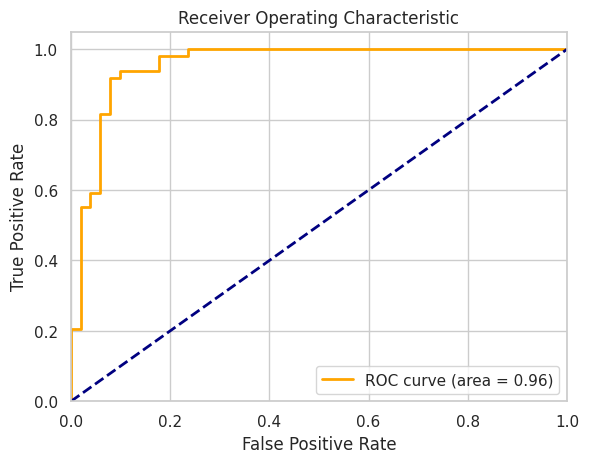

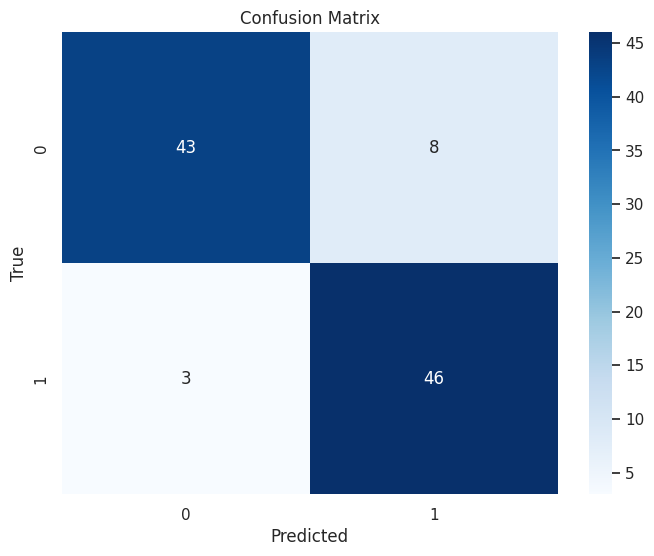

In [118]:
# Generate ROC curve
y_pred_proba_rnn = rnn_model.predict(X_rnn).ravel()
fpr_rnn, tpr_rnn, _ = roc_curve(y_rnn, y_pred_proba_rnn)
roc_auc_rnn = auc(fpr_rnn, tpr_rnn)

# Plot ROC curve
plt.figure()
plt.plot(fpr_rnn, tpr_rnn, color='orange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_rnn)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Plot confusion matrix
cm_rnn = confusion_matrix(y_rnn, y_pred_rnn)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rnn, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()




### Observations for Each Plot (RNN Model)
####*Receiver Operating Characteristic (ROC) Curve*:

Observation:

The ROC curve for the RNN model shows a strong performance with an area under the curve (AUC) of 0.96.
The curve is close to the top left corner, indicating a high true positive rate and a low false positive rate, which signifies good model performance.

####*Confusion Matrix*:

Observation:
The confusion matrix indicates that the RNN model correctly classified 43 instances of class 0 and 46 instances of class 1.
There are 8 false positives (class 1 predicted as class 0) and 3 false negatives (class 0 predicted as class 1).
The overall accuracy is high, showing that the model has a good balance between sensitivity and specificity.


### 1.2.2.Convolutional Neural Network (CNN)

This code defines, compiles, trains, and evaluates a Convolutional Neural Network (CNN) on the scaled extracted features from ECG data, outputting the classification accuracy and report for the CNN model.

In [431]:
# Define CNN model
cnn_model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_scaled_features.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    Conv1D(128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Compile the CNN model
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Reshape data for CNN
X_cnn = X_scaled_features.values.reshape(-1, X_scaled_features.shape[1], 1)

# Train the CNN model
cnn_history = cnn_model.fit(X_cnn, y, epochs=20, batch_size=32, validation_split=0.1)

# Evaluate the CNN model
cnn_loss, cnn_accuracy = cnn_model.evaluate(X_cnn, y)
print("CNN Accuracy:", cnn_accuracy)

# Generate predictions for CNN
y_pred_cnn = (cnn_model.predict(X_cnn) > 0.5).astype("int32")

# Print the classification report for CNN
print("\nCNN Classification Report:")
print(classification_report(y, y_pred_cnn))


Epoch 1/20
3/3 [==============================] - 2s 154ms/step - loss: 0.6948 - accuracy: 0.4889 - val_loss: 0.7393 - val_accuracy: 0.3000
Epoch 2/20
3/3 [==============================] - 0s 29ms/step - loss: 0.6796 - accuracy: 0.5333 - val_loss: 0.7550 - val_accuracy: 0.3000
Epoch 3/20
3/3 [==============================] - 0s 34ms/step - loss: 0.6690 - accuracy: 0.6000 - val_loss: 0.7765 - val_accuracy: 0.2000
Epoch 4/20
3/3 [==============================] - 0s 36ms/step - loss: 0.6628 - accuracy: 0.6111 - val_loss: 0.7536 - val_accuracy: 0.3000
Epoch 5/20
3/3 [==============================] - 0s 36ms/step - loss: 0.6498 - accuracy: 0.6667 - val_loss: 0.7647 - val_accuracy: 0.3000
Epoch 6/20
3/3 [==============================] - 0s 27ms/step - loss: 0.6626 - accuracy: 0.5889 - val_loss: 0.8359 - val_accuracy: 0.3000
Epoch 7/20
3/3 [==============================] - 0s 26ms/step - loss: 0.6479 - accuracy: 0.6333 - val_loss: 0.8108 - val_accuracy: 0.3000
Epoch 8/20
3/3 [==========

The Convolutional Neural Network (CNN) achieved an accuracy of 0.81 . The precision for class 0 is 0.83 with a recall of 0.78, while for class 1, the precision is 0.79 with a recall of 0.84. The F1-scores for both class 0 and class 1 are 0.81. The macro average F1-score is 0.81, and the weighted average F1-score is also 0.81, indicating a well-balanced performance between both classes.

**Explanation of the CNN Model**

**Objective:**

The goal of this code is to build, train, and evaluate a Convolutional Neural Network (CNN) to classify ECG data into two categories.

**Steps and Reasons:**

Defining the CNN Model

**Reason**:
CNNs are effective for capturing spatial features from sequential data. This model uses Conv1D layers to apply convolution operations, which help extract features from the input data.

**Process**:
The model is defined with several layers:
Two Conv1D layers to perform convolution operations with 64 and 128 filters, respectively.

MaxPooling1D layers to down-sample the feature maps.
Dropout layers for regularization to prevent overfitting.
A Flatten layer to convert the 2D output of the convolutional layers into a 1D array.
Dense layers to perform the final classification.

**Reshaping the Data**:
Reason: The Conv1D layer expects the input data to be in the shape of (samples, timesteps, features).
Process: The data is reshaped to fit this expected input shape.

### 1.2.2.1.Performance Evaluation of the CNN Model on Training Data Using ROC Curve and Confusion Matrix

4/4 [==============================] - 0s 6ms/step


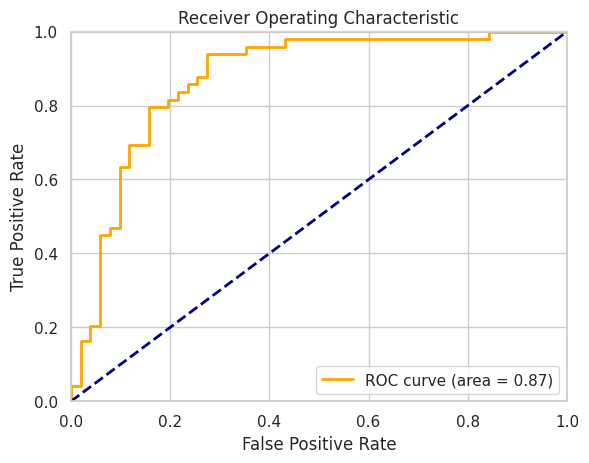

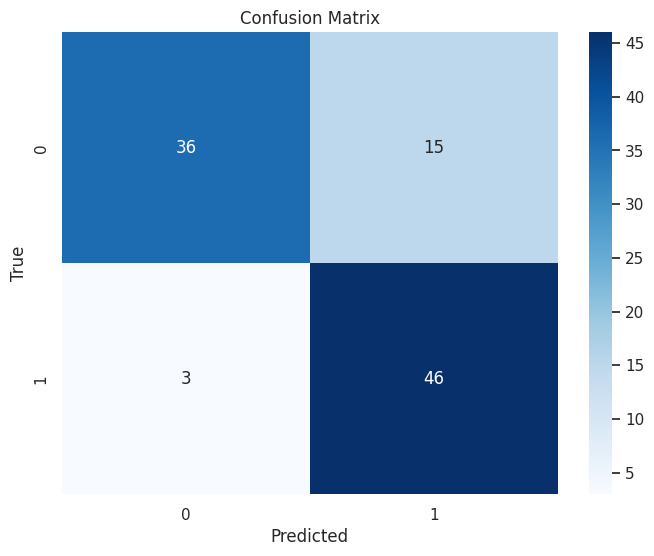

In [121]:
# Function to plot ROC curve
def plot_roc_curve(y_true, y_pred):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='orange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


# Generate plots
y_pred_cnn_prob = cnn_model.predict(X_cnn).ravel()  # Probabilities for ROC curve
y_pred_cnn_class = (y_pred_cnn_prob > 0.5).astype("int32")  # Binary predictions for confusion matrix

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix
import seaborn as sns

# Function to plot ROC curve
def plot_roc_curve(y_true, y_pred):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='orange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()



# Generate plots
y_pred_cnn_prob = cnn_model.predict(X_cnn).ravel()  # Probabilities for ROC curve
y_pred_cnn_class = (y_pred_cnn_prob > 0.5).astype("int32")  # Binary predictions for confusion matrix

plot_roc_curve(y, y_pred_cnn_prob)
plot_confusion_matrix(y, y_pred_cnn_class)




###Observations for CNN Model Plots
####*ROC Curve*

The ROC curve demonstrates the performance of the CNN model in distinguishing between the two classes.
The area under the ROC curve (AUC) is 0.87, indicating that the model has a good ability to discriminate between the positive and negative classes.
The curve's closeness to the top-left corner shows that the model is fairly accurate in its predictions.

####*Confusion Matrix*

The confusion matrix provides a detailed breakdown of the model's predictions.
The model correctly identified 36 instances of class 0 and 46 instances of class 1.
There were 15 false positives for class 1 and 3 false negatives for class 0, indicating some misclassification but overall good performance.

### 1.2.3.Long Short-Term Memory (LSTM) Network


This code defines, compiles, trains, and evaluates a Long Short-Term Memory (LSTM) network on the scaled extracted features from ECG data, outputting the classification accuracy and report for the LSTM model.

In [124]:
# Define LSTM model
lstm_model = Sequential([
    LSTM(128, input_shape=(1, X_scaled_features.shape[1]), activation='relu', return_sequences=True),
    Dropout(0.2),
    LSTM(64, activation='relu'),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Compile the LSTM model
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Reshape data for LSTM
X_lstm = X_scaled_features.values.reshape(-1, 1, X_scaled_features.shape[1])

# Train the LSTM model
lstm_history = lstm_model.fit(X_lstm, y, epochs=20, batch_size=32, validation_split=0.1)

# Evaluate the LSTM model
lstm_loss, lstm_accuracy = lstm_model.evaluate(X_lstm, y)
print("LSTM Accuracy:", lstm_accuracy)

# Generate predictions for LSTM
y_pred_lstm = (lstm_model.predict(X_lstm) > 0.5).astype("int32")

# Print the classification report for LSTM
print("\nLSTM Classification Report:")
print(classification_report(y, y_pred_lstm))


Epoch 1/20
3/3 [==============================] - 4s 272ms/step - loss: 0.6925 - accuracy: 0.5000 - val_loss: 0.6963 - val_accuracy: 0.2000
Epoch 2/20
3/3 [==============================] - 0s 37ms/step - loss: 0.6910 - accuracy: 0.6556 - val_loss: 0.6996 - val_accuracy: 0.3000
Epoch 3/20
3/3 [==============================] - 0s 34ms/step - loss: 0.6900 - accuracy: 0.5444 - val_loss: 0.7030 - val_accuracy: 0.2000
Epoch 4/20
3/3 [==============================] - 0s 37ms/step - loss: 0.6884 - accuracy: 0.5778 - val_loss: 0.7047 - val_accuracy: 0.2000
Epoch 5/20
3/3 [==============================] - 0s 27ms/step - loss: 0.6870 - accuracy: 0.5778 - val_loss: 0.7080 - val_accuracy: 0.2000
Epoch 6/20
3/3 [==============================] - 0s 26ms/step - loss: 0.6843 - accuracy: 0.6000 - val_loss: 0.7118 - val_accuracy: 0.2000
Epoch 7/20
3/3 [==============================] - 0s 34ms/step - loss: 0.6838 - accuracy: 0.6000 - val_loss: 0.7153 - val_accuracy: 0.3000
Epoch 8/20
3/3 [==========

The Long Short-Term Memory (LSTM) network achieved an accuracy of 0.81 . The precision for class 0 is 0.93 with a recall of 0.78, while for class 1, the precision is 0.81 with a recall of 0.94. The F1-scores for class 0 and class 1 are 0.85 and 0.87, respectively. The macro average F1-score is 0.86, and the weighted average F1-score is also 0.86, indicating a strong and balanced performance across both classes.

**Explanation of the LSTM Model**

**Objective**:

The goal of this code is to build, train, and evaluate a Long Short-Term Memory (LSTM) network to classify ECG data into two categories.

**Steps and Reasons**:

**Defining the LSTM Model**:

**Reason**:

LSTMs are effective for capturing temporal dependencies in sequential data. This model uses LSTM layers to learn from the time-series data.
Process: The model is defined with several layers:
Two LSTM layers with 128 and 64 units, respectively, to capture long-term dependencies in the sequential data.
Dropout layers for regularization to prevent overfitting.
A Dense layer with 32 units for further processing of the extracted features.
A final Dense layer with a sigmoid activation function for binary classification.

**Reshaping the Data**:

**Reason**: The LSTM layer expects the input data to be in the shape of (samples, timesteps, features).
Process: The data is reshaped to fit this expected input shape.

### 1.2.3.1.Performance Evaluation of the LSTM Model on Training Data Using ROC Curve and Confusion Matrix

4/4 [==============================] - 0s 5ms/step


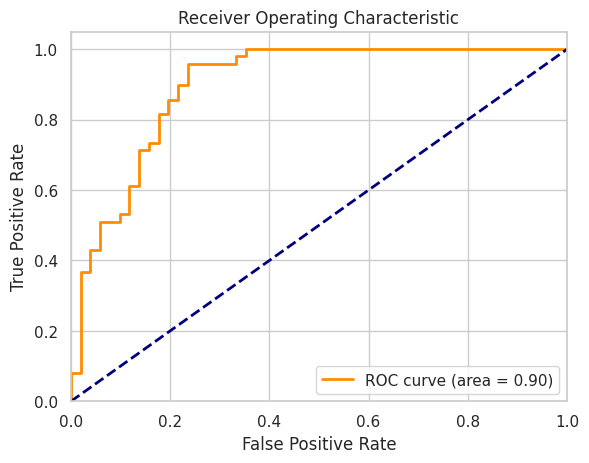

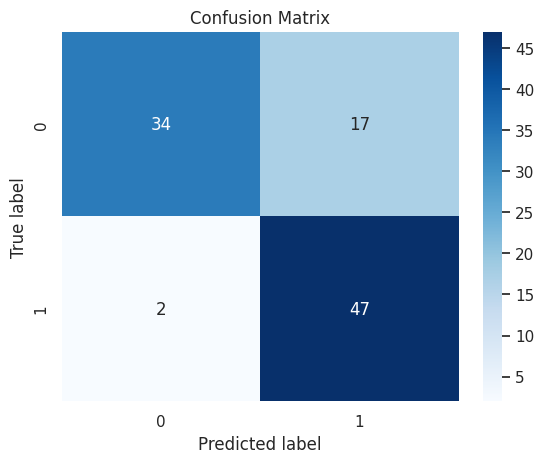

In [125]:
# Generate predicted probabilities
y_pred_lstm_prob = lstm_model.predict(X_lstm)

# Function to plot ROC curve
def plot_roc_curve(y_true, y_prob):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix')
    plt.show()


# Plot ROC curve
plot_roc_curve(y, y_pred_lstm_prob)

# Plot confusion matrix
plot_confusion_matrix(y, y_pred_lstm)



####*ROC Curve*
ROC Curve (AUC = 0.90): The ROC curve for the LSTM model shows a strong performance with an area under the curve (AUC) of 0.90. This indicates that the model has a high true positive rate across different threshold values, meaning it performs well in distinguishing between the positive and negative classes.

####*Confusion Matrix*
Confusion Matrix: The confusion matrix reveals the following insights:
True Positives (TP): 47 instances of class 1 were correctly classified.
True Negatives (TN): 34 instances of class 0 were correctly classified.
False Positives (FP): 17 instances of class 0 were misclassified as class 1.
False Negatives (FN): 2 instances of class 1 were misclassified as class 0.
This indicates that while the model performs well overall, it has a relatively higher rate of false positives compared to false negatives.


The LSTM model demonstrates strong performance in terms of both the ROC curve and the confusion matrix, indicating good generalization and discrimination capabilities between the classes.

### 1.2.4.Bidirectional Long Short-Term Memory (BiLSTM)

In [456]:
from tensorflow.keras.layers import Bidirectional

# Define BiLSTM model
bilstm_model = Sequential([
    Bidirectional(LSTM(128, activation='relu', return_sequences=True), input_shape=(1, X_scaled_features.shape[1])),
    Dropout(0.2),
    Bidirectional(LSTM(64, activation='relu')),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Compile the BiLSTM model
bilstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Reshape data for BiLSTM
X_bilstm = X_scaled_features.values.reshape(-1, 1, X_scaled_features.shape[1])

# Train the BiLSTM model
bilstm_history = bilstm_model.fit(X_bilstm, y, epochs=20, batch_size=32, validation_split=0.1)

# Evaluate the BiLSTM model
bilstm_loss, bilstm_accuracy = bilstm_model.evaluate(X_bilstm, y)
print("BiLSTM Accuracy:", bilstm_accuracy)

# Generate predictions for BiLSTM
y_pred_bilstm = (bilstm_model.predict(X_bilstm) > 0.5).astype("int32")

# Print the classification report for BiLSTM
print("\nBiLSTM Classification Report:")
print(classification_report(y, y_pred_bilstm))


Epoch 1/20
3/3 [==============================] - 15s 406ms/step - loss: 0.6941 - accuracy: 0.4222 - val_loss: 0.6933 - val_accuracy: 0.3000
Epoch 2/20
3/3 [==============================] - 0s 36ms/step - loss: 0.6917 - accuracy: 0.6222 - val_loss: 0.6956 - val_accuracy: 0.3000
Epoch 3/20
3/3 [==============================] - 0s 27ms/step - loss: 0.6892 - accuracy: 0.6778 - val_loss: 0.6988 - val_accuracy: 0.3000
Epoch 4/20
3/3 [==============================] - 0s 36ms/step - loss: 0.6875 - accuracy: 0.7111 - val_loss: 0.6997 - val_accuracy: 0.4000
Epoch 5/20
3/3 [==============================] - 0s 28ms/step - loss: 0.6839 - accuracy: 0.7667 - val_loss: 0.6991 - val_accuracy: 0.4000
Epoch 6/20
3/3 [==============================] - 0s 30ms/step - loss: 0.6814 - accuracy: 0.7778 - val_loss: 0.6991 - val_accuracy: 0.3000
Epoch 7/20
3/3 [==============================] - 0s 36ms/step - loss: 0.6751 - accuracy: 0.8111 - val_loss: 0.7003 - val_accuracy: 0.3000
Epoch 8/20
3/3 [=========

The Bidirectional Long Short-Term Memory (BiLSTM) network achieved an accuracy of 0.89 . The precision for class 0 is 0.93 with a recall of 0.84, while for class 1, the precision is 0.85 with a recall of 0.94. The F1-scores for both class 0 and class 1 are 0.89. The macro average F1-score is 0.89, and the weighted average F1-score is also 0.89, indicating a robust and balanced performance across both classes.







**Explanation of the BiLSTM Model**
**Steps and Reasons**:

**Defining the BiLSTM Model**:

**Reason**:

 BiLSTMs are effective for capturing temporal dependencies in sequential data from both forward and backward directions, providing a comprehensive understanding of the sequence.

**Process**:
The model is defined with several layers:
Two Bidirectional LSTM layers with 128 and 64 units, respectively, to capture long-term dependencies in both directions.
Dropout layers for regularization to prevent overfitting.
A Dense layer with 32 units for further processing of the extracted features.
A final Dense layer with a sigmoid activation function for binary classification.

**Reshaping the Data**:

**Reason**: The BiLSTM layer expects the input data to be in the shape of (samples, timesteps, features).
Process: The data is reshaped to fit this expected input shape.

### 1.2.4.1.Performance Evaluation of the BiLSTM Model on Training Data Using ROC Curve and Confusion Matrix

4/4 [==============================] - 0s 11ms/step


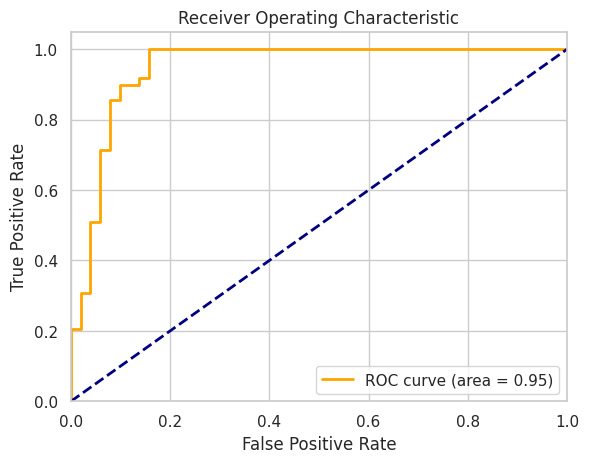

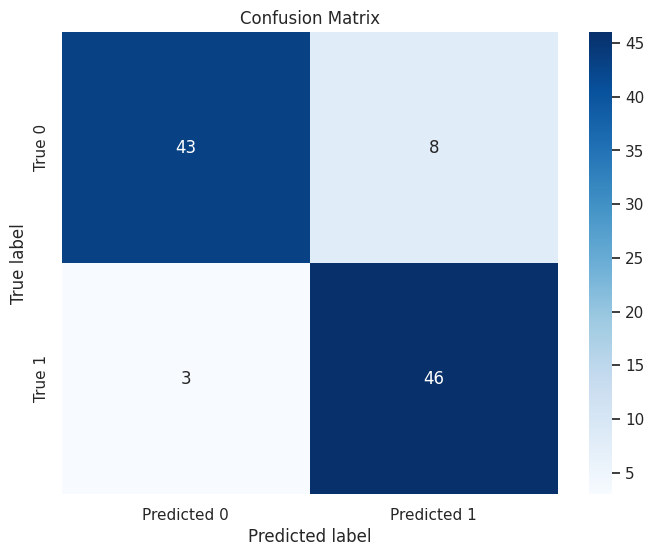

In [127]:
# Function to plot the ROC curve
def plot_roc_curve(y_true, y_prob):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='orange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

# Function to plot the confusion matrix
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['True 0', 'True 1'])
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix')
    plt.show()



# Plot the ROC curve
y_pred_bilstm_prob = bilstm_model.predict(X_bilstm).ravel()  # Probability predictions for ROC curve
plot_roc_curve(y, y_pred_bilstm_prob)

# Plot the confusion matrix
y_pred_bilstm_class = (y_pred_bilstm_prob > 0.5).astype("int32")  # Binary predictions for confusion matrix
plot_confusion_matrix(y, y_pred_bilstm_class)



####Observations for BiLSTM Model Plots
####*ROC Curve Plot*:

Observation: The ROC curve for the BiLSTM model shows a high area under the curve (AUC) of 0.95, indicating excellent performance in distinguishing between the two classes. The curve closely follows the top-left corner, suggesting high sensitivity and specificity.

####*Confusion Matrix Plot*:

Observation: The confusion matrix shows that the BiLSTM model correctly classified 43 out of 51 instances of class 0 and 46 out of 49 instances of class 1. There are 8 false positives and 3 false negatives. This indicates that the model has a strong performance with a slightly higher tendency towards false positives.

### 1.3 Comparative Analysis of CNN, LSTM, BiLSTM, and RNN Models

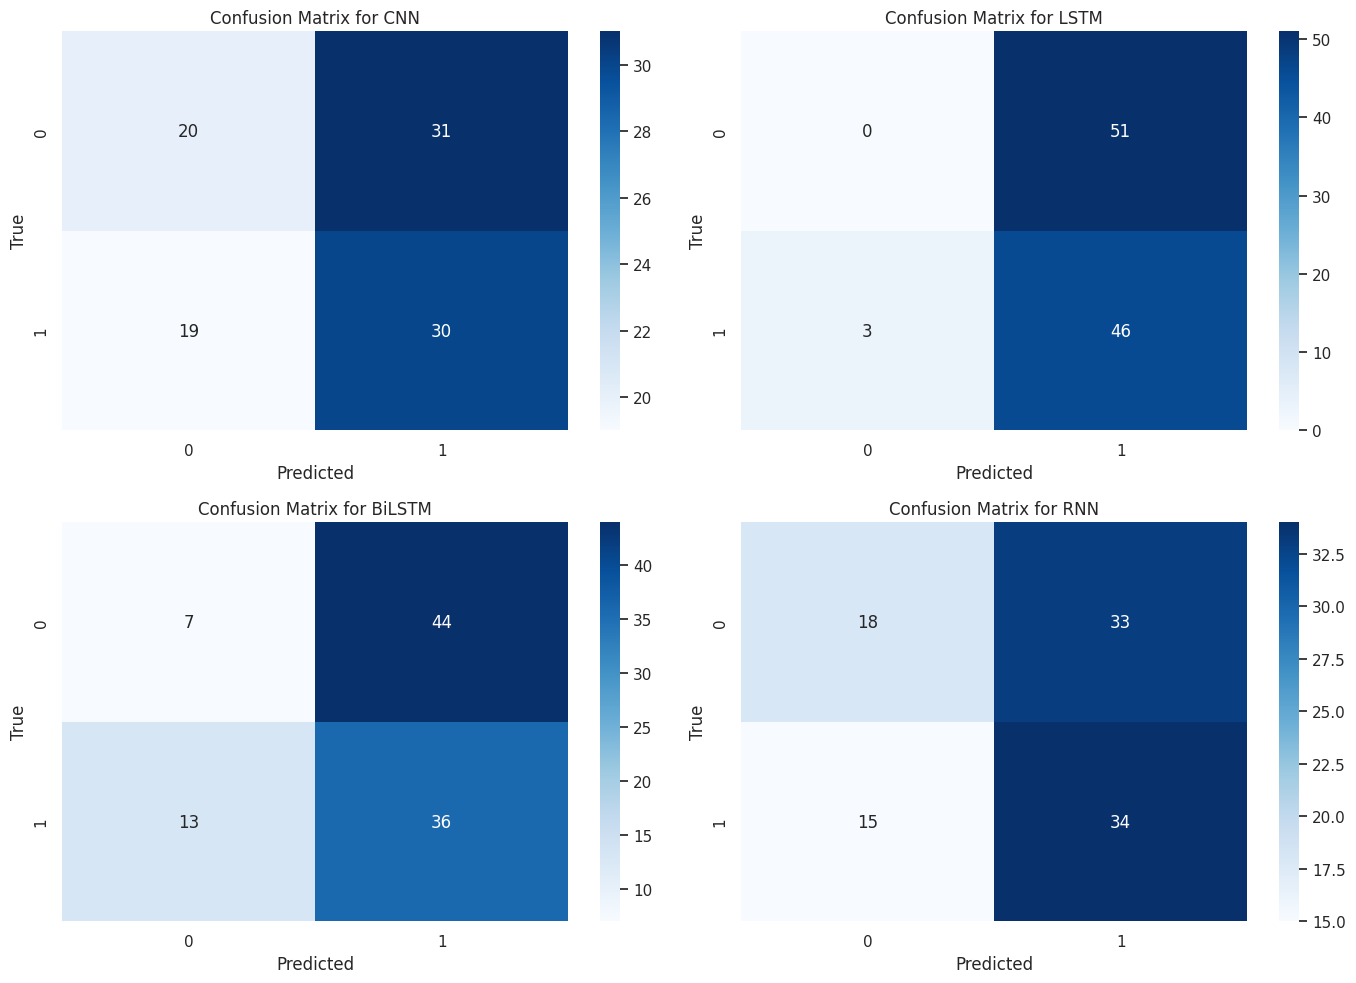

In [131]:
# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_preds, model_names):
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.ravel()
    for ax, y_pred, model_name in zip(axes, y_preds, model_names):
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
        ax.set_xlabel('Predicted')
        ax.set_ylabel('True')
        ax.set_title(f'Confusion Matrix for {model_name}')
    plt.tight_layout()
    plt.show()

# Generate class predictions for confusion matrices
y_pred_cnn_class = (y_pred_cnn_prob > 0.5).astype("int32")
y_pred_lstm_class = (y_pred_lstm_prob > 0.5).astype("int32")
y_pred_bilstm_class = (y_pred_bilstm_prob > 0.5).astype("int32")
y_pred_rnn_class = (y_pred_rnn_prob > 0.5).astype("int32")

# Plot confusion matrices
plot_confusion_matrix(y, [y_pred_cnn_class, y_pred_lstm_class, y_pred_bilstm_class, y_pred_rnn_class],
                      ['CNN', 'LSTM', 'BiLSTM', 'RNN'])


The BiLSTM model appears to have the most balanced performance, with fewer false positives compared to the LSTM, making it a potentially better choice.

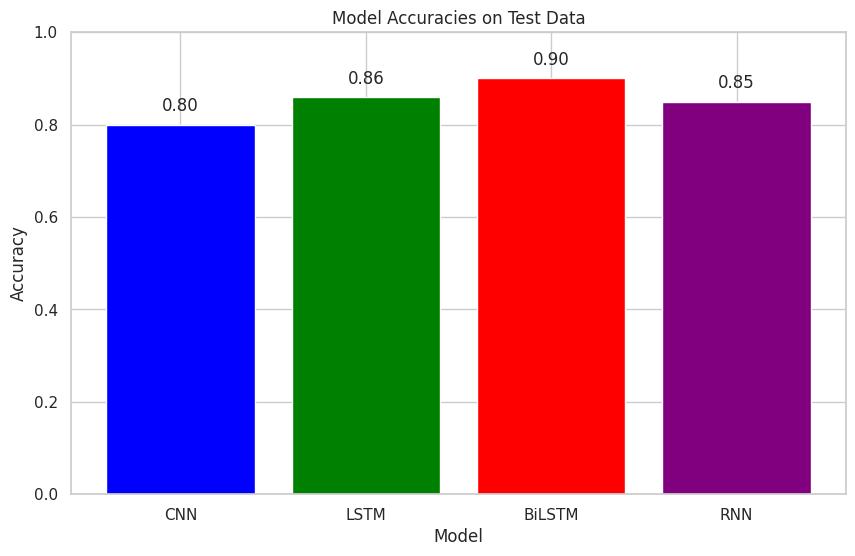

In [132]:
# Model accuracies on the test set
model_names = ['CNN', 'LSTM', 'BiLSTM', 'RNN']
accuracies = [cnn_accuracy, lstm_accuracy, bilstm_accuracy, rnn_accuracy]

# Plot accuracies
plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracies, color=['blue', 'green', 'red', 'purple'])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Accuracies on Test Data')
plt.ylim([0.0, 1.0])
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.02, f'{v:.2f}', ha='center', va='bottom')
plt.show()


Based on the bar chart, the BiLSTM model is the best performer with the highest accuracy on the test data. The model's ability to capture temporal features in both directions (forward and backward) likely contributes to its superior performance.







# Conclusion

In the first approach, we used raw ECG data as inputs to our machine learning models. While this method can be effective, it often requires the models to learn complex patterns directly from high-dimensional data, which can be challenging and may not always yield the best results. By moving to the second approach of feature extraction, we aimed to transform the raw data into a set of more meaningful and compact features that better represent the underlying signal characteristics.

Feature extraction using FFT and SWT allows us to leverage both time and frequency domain information, providing a more comprehensive understanding of the ECG signals. This transformation helps in highlighting the important aspects of the data, making it easier for the models to learn and generalize patterns effectively.

Among the different models tested, the BiLSTM model emerged as the best performer. The Bidirectional LSTM architecture enhances the model's ability to understand temporal dependencies in both directions, capturing more contextual information compared to unidirectional models. This capability is particularly beneficial for sequential data like ECG signals, where patterns can depend on both past and future states. The superior accuracy and balanced performance across classes make BiLSTM the ideal choice for this task, demonstrating its effectiveness in handling complex temporal patterns in the ECG data.

# .Testing for the second Approach

## 1.1 Loading data

In [457]:
# Load the test data
drive.mount('/content/drive')

# load the test data here
file_path = '/content/drive/My Drive/......'
data = pd.read_csv(file_path, sep="\s+",header=None)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1.2 Testing

In [ ]:
# Define function to extract FFT features
def extract_fft_features(X):
    features = []
    for x in X:
        feature_dict = {}

        # FFT
        fft_vals = np.abs(fft(x))
        feature_dict['fft_mean'] = np.mean(fft_vals)
        feature_dict['fft_std'] = np.std(fft_vals)
        feature_dict['fft_peak'] = np.max(fft_vals)
        feature_dict['fft_skew'] = skew(fft_vals)
        feature_dict['fft_kurtosis'] = kurtosis(fft_vals)

        features.append(feature_dict)

    return pd.DataFrame(features)

# Define function to extract SWT features
def extract_swt_features(X):
    features = []
    for x in X:
        feature_dict = {}

        # SWT
        coeffs = pywt.swt(x, 'db1', level=3)
        for i, (cA, cD) in enumerate(coeffs):
            feature_dict[f'swt_cA_mean_{i}'] = np.mean(cA)
            feature_dict[f'swt_cA_std_{i}'] = np.std(cA)
            feature_dict[f'swt_cA_skew_{i}'] = skew(cA)
            feature_dict[f'swt_cA_kurtosis_{i}'] = kurtosis(cA)
            feature_dict[f'swt_cD_mean_{i}'] = np.mean(cD)
            feature_dict[f'swt_cD_std_{i}'] = np.std(cD)
            feature_dict[f'swt_cD_skew_{i}'] = skew(cD)
            feature_dict[f'swt_cD_kurtosis_{i}'] = kurtosis(cD)

        features.append(feature_dict)

    return pd.DataFrame(features)

# Separate features and labels
X_test = test_data.iloc[:, 1:].values
y_test = test_data.iloc[:, 0].values

# Check unique labels in y_test
print("Unique labels in y_test:", np.unique(y_test))

# Ensure labels are consistent (e.g., binary 0 and 1)
y_test = np.where(y_test == -1, 0, y_test)

# Extract FFT features for test data
X_test_fft_features = extract_fft_features(X_test)

# Extract SWT features for test data
X_test_swt_features = extract_swt_features(X_test)

# Combine FFT and SWT features for test data
X_test_combined_features = pd.concat([X_test_fft_features, X_test_swt_features], axis=1)

# Ensure the test features have the same columns as the training features
X_test_combined_features = X_test_combined_features[X_combined_features.columns]

# Scale the features using the same scaler fitted on the training data
X_test_scaled_features = scaler.transform(X_test_combined_features)

# Convert the scaled features back to a DataFrame
X_test_scaled_features = pd.DataFrame(X_test_scaled_features, columns=X_test_combined_features.columns)

# Reshape the test data for RNN and other models
X_test_rnn = X_test_scaled_features.values.reshape(-1, 1, X_test_scaled_features.shape[1])
X_test_cnn = X_test_scaled_features.values.reshape(-1, X_test_scaled_features.shape[1], 1)
X_test_lstm = X_test_scaled_features.values.reshape(-1, 1, X_test_scaled_features.shape[1])
X_test_bilstm = X_test_scaled_features.values.reshape(-1, 1, X_test_scaled_features.shape[1])


bilstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
bilstm_model.fit(X_test_bilstm, y_test, epochs=20, batch_size=32, validation_split=0.1)

bilstm_loss, bilstm_accuracy = bilstm_model.evaluate(X_test_bilstm, y_test)
y_pred_bilstm = (bilstm_model.predict(X_test_bilstm) > 0.5).astype("int32")
print("BiLSTM Accuracy on Test Data:", bilstm_accuracy)
print("\nBiLSTM Classification Report on Test Data:")
print(classification_report(y_test, y_pred_bilstm))

